# <u>*Correlation Between Billionaire Status and Resident Country*<u>

In [1]:
# refs
# https://www.heritage.org/index/download
# https://datahub.io/core/geo-countries#resource-geo-countries_zip

## Imports, Configuration

In [2]:
import pandas as pd
import numpy as np
import geopandas as geo
import geoplot as gplot
import country_converter as converter
import mapclassify as mc
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ='retina'

## Helper Functions

In [3]:
def plot_colormaps(cmap):
    fig, ax = plt.subplots(figsize=(4,0.4))
    col_map = plt.get_cmap(cmap)
    mpl.colorbar.ColorbarBase(ax, cmap=col_map, orientation = 'horizontal')
    plt.show()
    
def print_cmaps():
    for cmap_id in plt.colormaps():
        print(cmap_id)
        plot_colorMaps(cmap_id)
        
def lin_reg(x,y):
    # Calculate the average x and y
    x_avg = np.mean(x)
    y_avg = np.mean(y)

    num = 0
    den = 0
    for i in range(len(x)): # This represents our sums
        num = num + (x[i] - x_avg)*(y[i] - y_avg) # Our numerator
        den = den + (x[i] - x_avg)**2 # Our denominator
    # Calculate slope
    m = num / den
    # Calculate intercept
    b = y_avg - m*x_avg

    print (m, b)
    
    # Calculate our predicted y values
    y_pred = m*x + b
    
    return y_pred

## Components
###### [CR] : Core Reference
###### [CN] : Component N, where N is equal to the component number

In [4]:
# load
billionaires = pd.read_csv('../data/billionaire.csv')
bpc = geo.read_file('../data/countries.geojson')
eco = pd.read_csv('../data/eco.csv')

In [5]:
# filter
billionaires = billionaires[~billionaires['Name'].str.contains('family')]
result = billionaires['Country'].value_counts()
b = pd.DataFrame()
b['Country'] = result.index
b['Billionaire_count'] = result.values
cc = converter.CountryConverter()
b['ISO_A3'] = cc.convert(b['Country'],to='ISO3')
b.drop('Country', axis=1, inplace=True)
b_normal = b.copy()
# b_normal['Billionaire_count'] = (b_normal['Billionaire_count']-b_normal['Billionaire_count'].min())/(b_normal['Billionaire_count'].max()-b_normal['Billionaire_count'].min())*100

eco.drop(columns=['CountryID', 
                  'WEBNAME', 
                  'Region', 
                  '2021 Score',
                  'World Rank', 
                  'Region Rank',
                  'Country', 
                  'Population (Millions)',
                  'Tax Burden',
                  'Govt Spending',
                  'Govt Expenditure % of GDP ',
                  'GDP (Billions, PPP)',
                  'GDP Growth Rate (%)',
                  '5 Year GDP Growth Rate (%)',
                  'GDP per Capita (PPP)',
                  'Unemployment (%)',
                  'Inflation (%)',
                  'FDI Inflow (Millions)',
                  'Public Debt (% of GDP)'
                 ],
        axis=1,
        inplace=True)
cc = converter.CountryConverter()
eco['ISO_A3'] = cc.convert(eco['Country Name'],
                           to='ISO3')
eco.drop('Country Name', axis=1, inplace=True)
eco = eco.rename(columns={'Property Rights': 'prop_frdm',
                          'Judical Effectiveness': 'judi_efct',
                          'Government Integrity': 'govt_intg',
                          'Fiscal Health': 'fscl_hlth',
                          'Business Freedom': 'bsns_frdm',
                          'Labor Freedom': 'labr_frdm',
                          'Monetary Freedom': 'mone_frdm',
                          'Trade Freedom': 'trad_frdm',
                          'Investment Freedom ': 'ivst_frdm',
                          'Financial Freedom': 'fina_frdm',
                          'Tariff Rate (%)': 'trff_rate',
                          'Income Tax Rate (%)': 'incm_tax_rate',
                          'Corporate Tax Rate (%)': 'corp_tax_rate',
                          'Tax Burden % of GDP': 'tax_burd_gdp',
                         })

#### *[CR] Billionaires Per Country (BPC)*

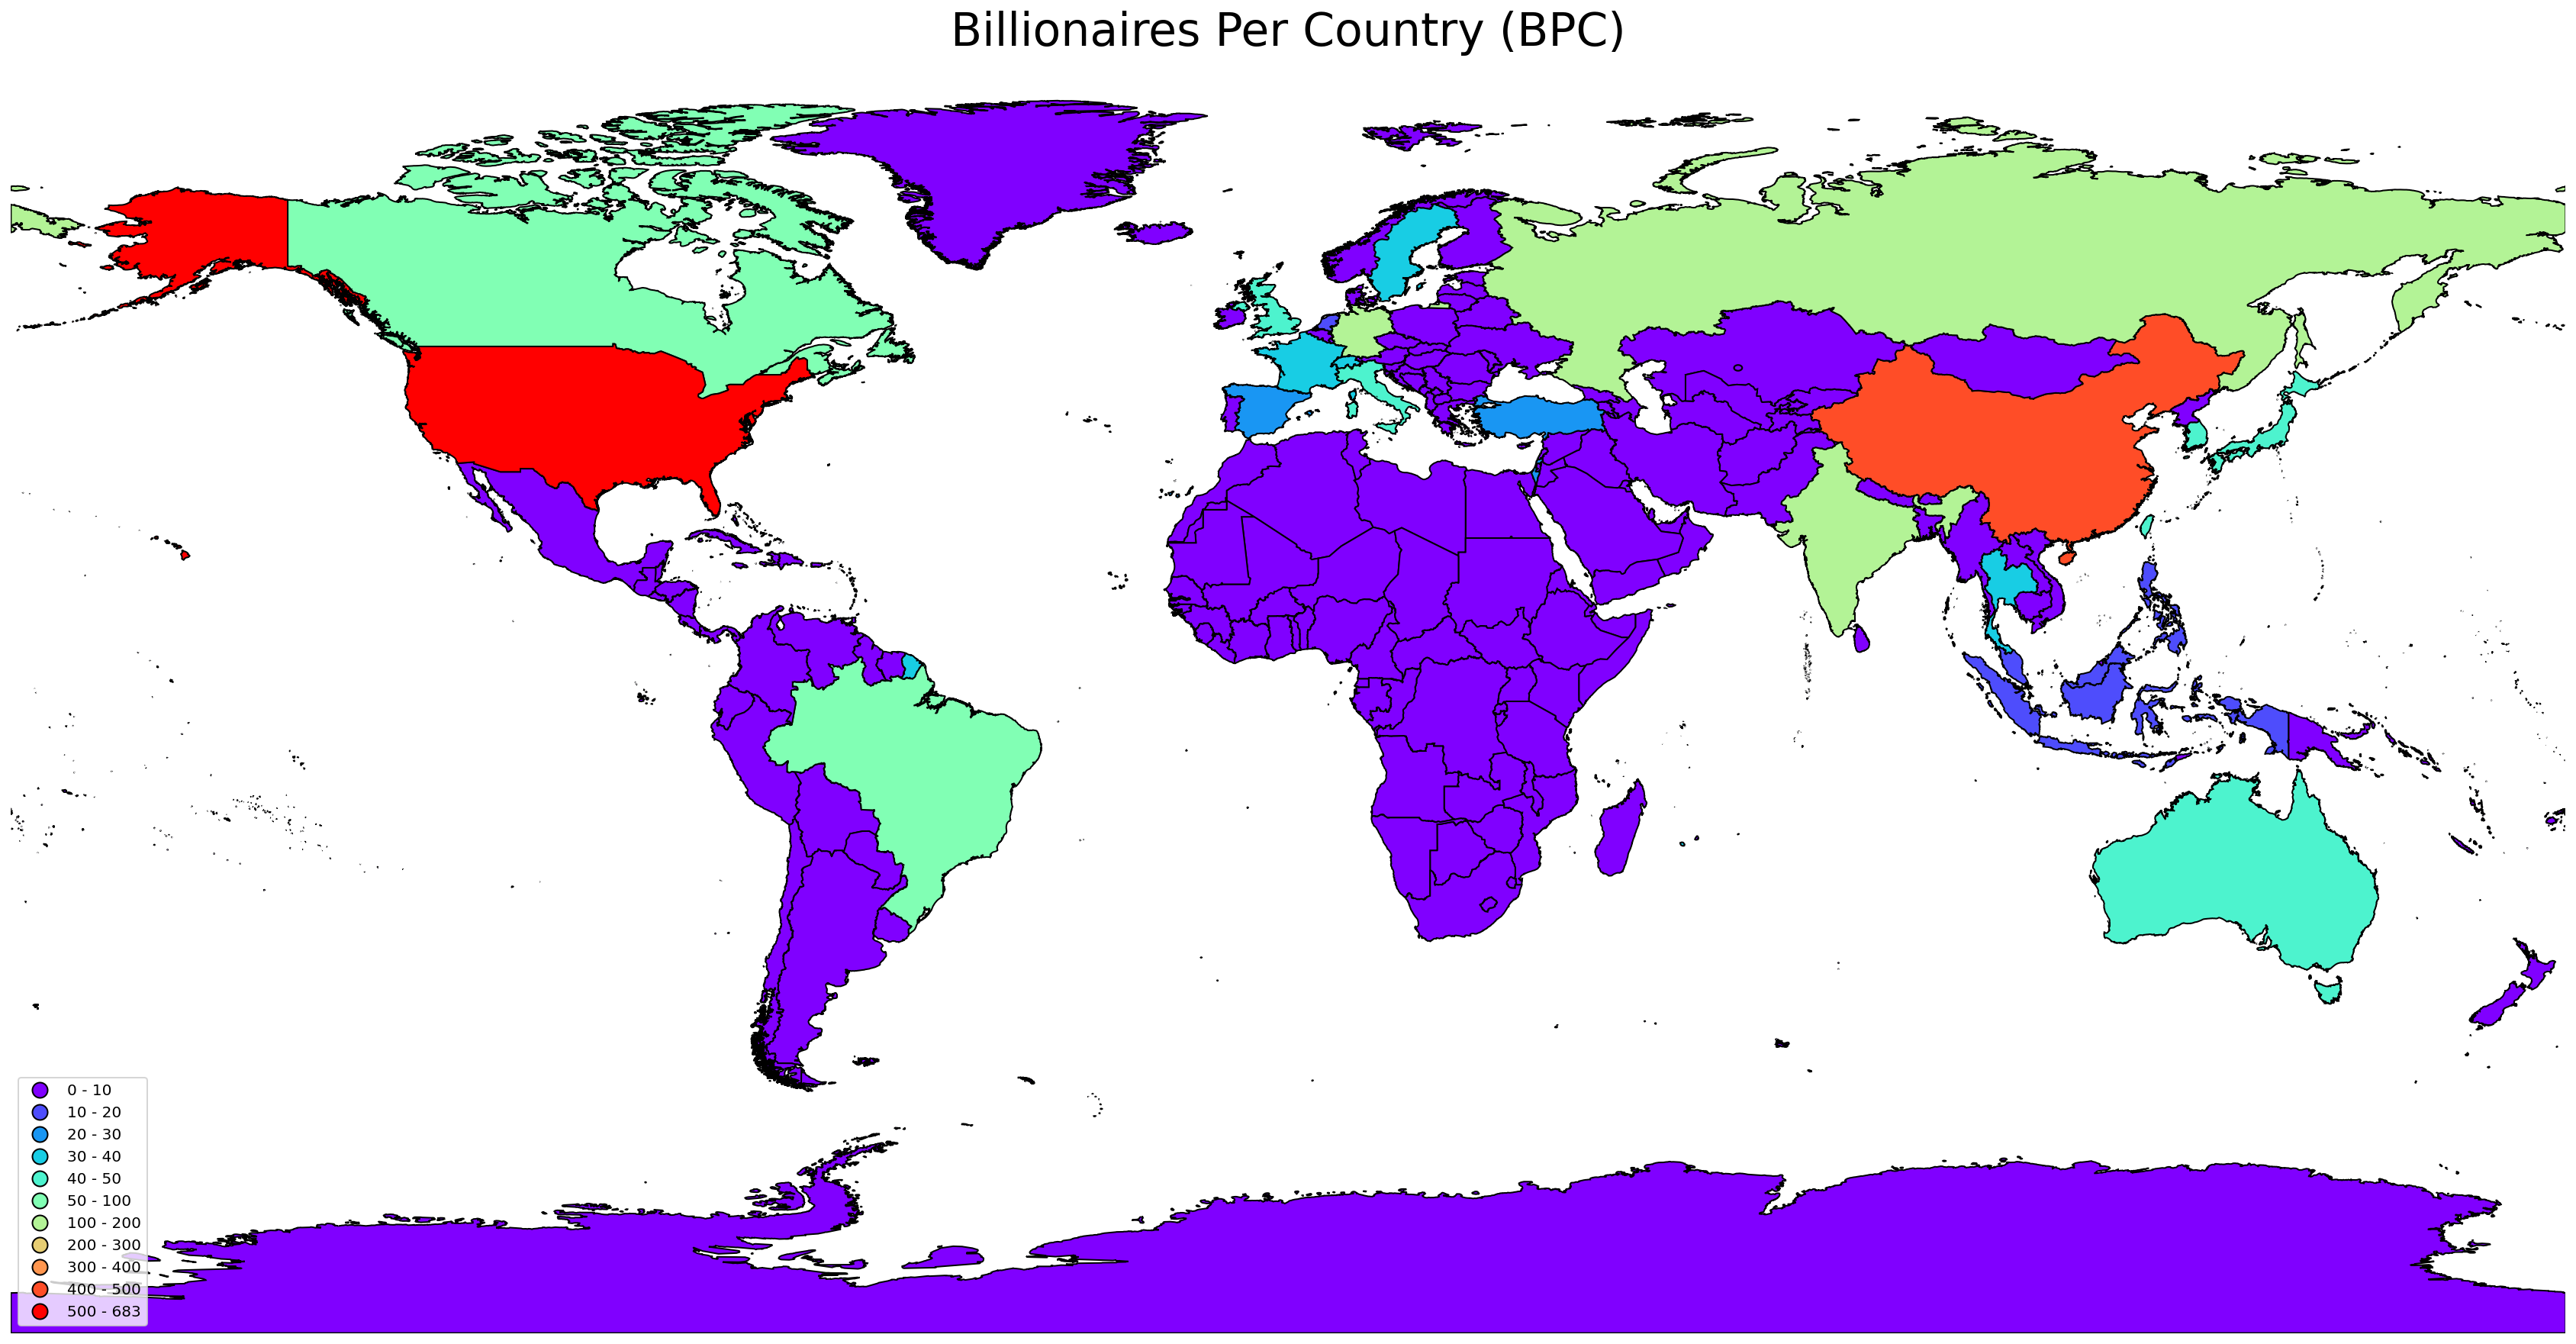

In [6]:
bpc = pd.merge(bpc, b, left_on='ISO_A3', right_on='ISO_A3', how='outer')
bpc['Billionaire_count'] = bpc['Billionaire_count'].apply(lambda x: 0 if np.isnan(x) else x)

fig, ax = plt.subplots(1, 1, figsize=(30, 30))
ud = mc.UserDefined(bpc['Billionaire_count'], 
                    [10, 20, 30, 40, 50, 100, 200, 300, 400, 500])
gplot.choropleth(bpc,
                hue='Billionaire_count',
                linewidth=1,
                scheme=ud,
                cmap='rainbow',
                legend=True,
                legend_kwargs={'loc': 'lower left'},
                edgecolor='black',
                ax=ax)
ax.set_title('Billionaires Per Country (BPC)', fontsize=30)

plt.savefig('output/bpc.png')

#### *[C1] Freedom Index (FI)*

0.4650043834784864 0.48749978640348474
0.4202509978887687 0.6224762120473738
0.24377476272325202 0.6024209770447593
0.07772238274827632 0.8268768062811619
0.2057987279195102 0.7052060856143016
0.264956452449667 0.5060412986448762
0.14166446277774417 0.5663373562969773


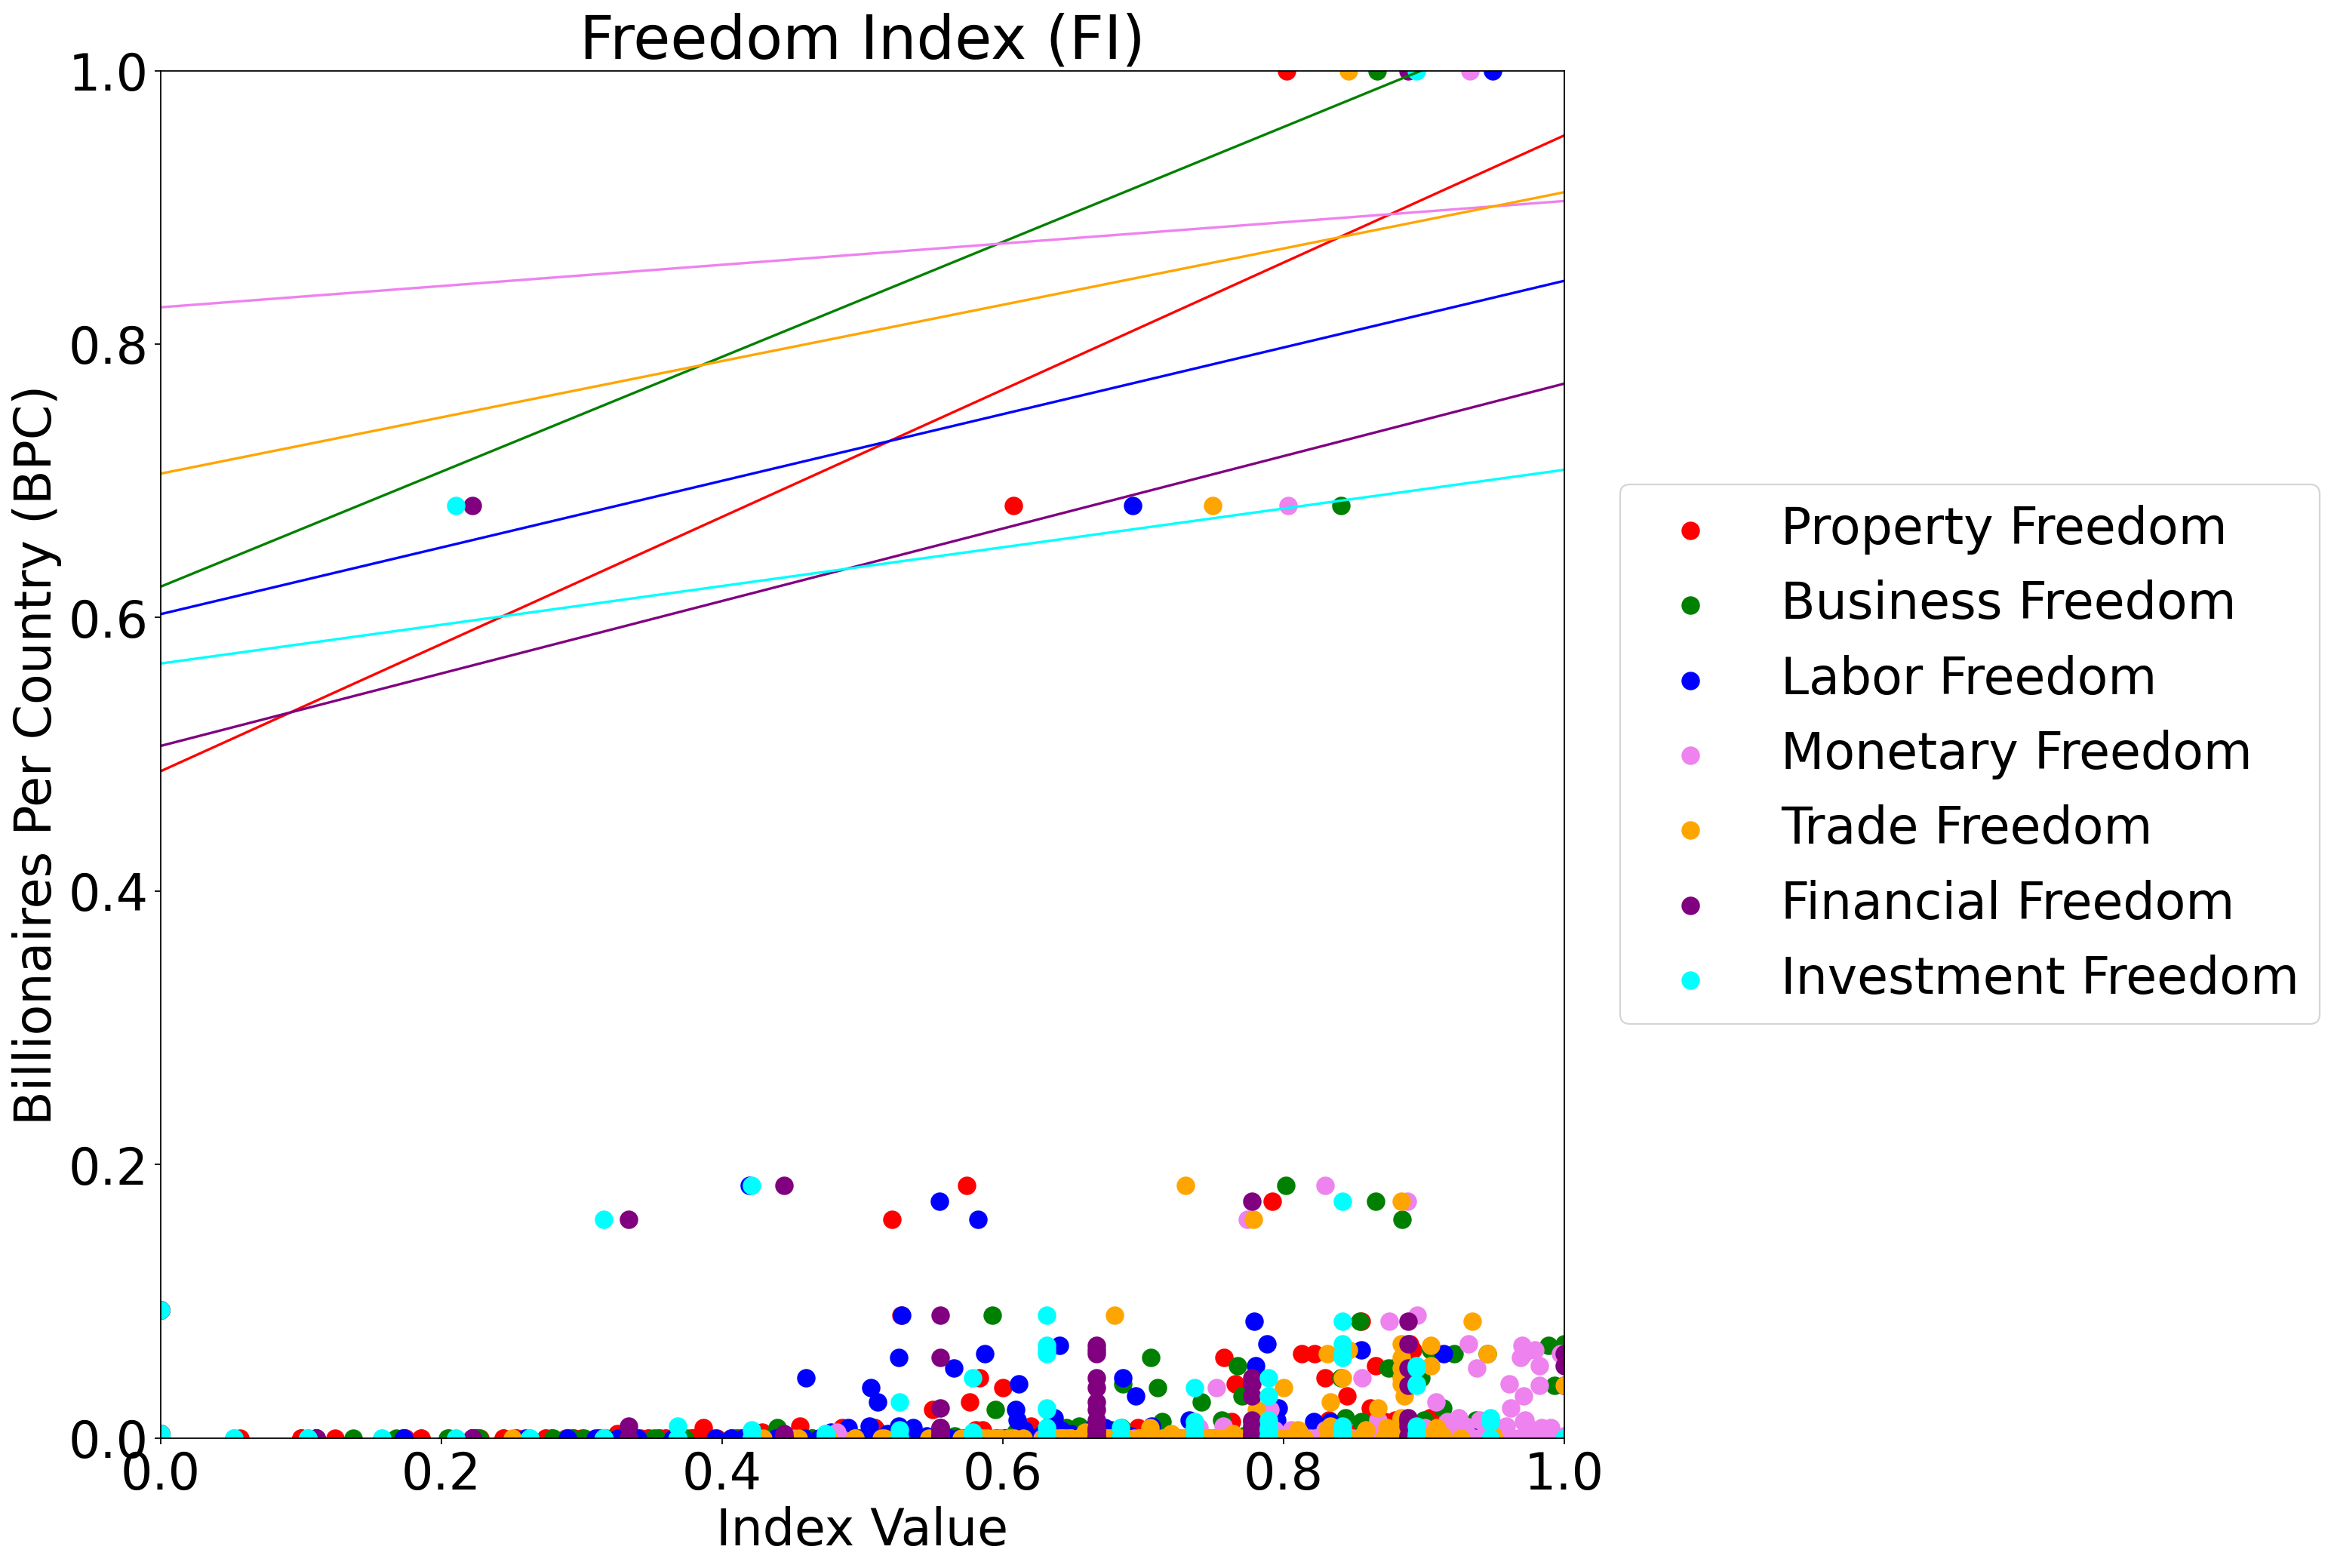

In [7]:
fi = eco[['prop_frdm', 'bsns_frdm', 'labr_frdm', 'mone_frdm', 'trad_frdm', 'fina_frdm', 'ivst_frdm', 'ISO_A3']]
fi = pd.merge(fi, b_normal, left_on='ISO_A3', right_on='ISO_A3', how='outer')
fi.drop(columns='ISO_A3', axis=1, inplace=True)
for col in fi:
    fi[col] = fi[col].apply(lambda x: 0 if np.isnan(x) else (x-fi[col].min())/(fi[col].max()-fi[col].min()))

plt.figure(figsize=(15,15),dpi=80)
plt.rcParams.update({'font.size':30})
plt.title('Freedom Index (FI)')
plt.xlabel('Index Value')
plt.ylabel('Billionaires Per Country (BPC)')
plt.figsize=(15,15)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.scatter(fi['prop_frdm'],
            fi['Billionaire_count'],
            s=100,
            c='red',
            label='Property Freedom')
plt.scatter(fi['bsns_frdm'],
            fi['Billionaire_count'],
            s=100,
            c='green',
            label='Business Freedom')
plt.scatter(fi['labr_frdm'],
            fi['Billionaire_count'],
            s=100,
            c='blue',
            label='Labor Freedom')
plt.scatter(fi['mone_frdm'],
            fi['Billionaire_count'],
            s=100,
            c='violet',
            label='Monetary Freedom')
plt.scatter(fi['trad_frdm'],
            fi['Billionaire_count'],
            s=100,
            c='orange',
            label='Trade Freedom')
plt.scatter(fi['fina_frdm'],
            fi['Billionaire_count'],
            s=100,
            c='purple',
            label='Financial Freedom')
plt.scatter(fi['ivst_frdm'],
            fi['Billionaire_count'],
            s=100,
            c='aqua',
            label='Investment Freedom')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

X=fi['Billionaire_count'].values
Y=fi['prop_frdm'].values
Y_pred = lin_reg(X,Y)
plt.plot([min(fi['Billionaire_count'].values), 
          max(fi['prop_frdm'].values)], 
         [min(Y_pred), max(Y_pred)], 
         color='red')
X=fi['Billionaire_count'].values
Y=fi['bsns_frdm'].values
Y_pred = lin_reg(X,Y)
plt.plot([min(fi['Billionaire_count'].values), 
          max(fi['bsns_frdm'].values)], 
         [min(Y_pred), max(Y_pred)], 
         color='green')
X=fi['Billionaire_count'].values
Y=fi['labr_frdm'].values
Y_pred = lin_reg(X,Y)
plt.plot([min(fi['Billionaire_count'].values), 
          max(fi['labr_frdm'].values)], 
         [min(Y_pred), max(Y_pred)], 
         color='blue')
X=fi['Billionaire_count'].values
Y=fi['mone_frdm'].values
Y_pred = lin_reg(X,Y)
plt.plot([min(fi['Billionaire_count'].values), 
          max(fi['mone_frdm'].values)], 
         [min(Y_pred), max(Y_pred)], 
         color='violet')
X=fi['Billionaire_count'].values
Y=fi['trad_frdm'].values
Y_pred = lin_reg(X,Y)
plt.plot([min(fi['Billionaire_count'].values), 
          max(fi['trad_frdm'].values)], 
         [min(Y_pred), max(Y_pred)], 
         color='orange')
X=fi['Billionaire_count'].values
Y=fi['fina_frdm'].values
Y_pred = lin_reg(X,Y)
plt.plot([min(fi['Billionaire_count'].values), 
          max(fi['fina_frdm'].values)], 
         [min(Y_pred), max(Y_pred)], 
         color='purple')
X=fi['Billionaire_count'].values
Y=fi['ivst_frdm'].values
Y_pred = lin_reg(X,Y)
plt.plot([min(fi['Billionaire_count'].values), 
          max(fi['ivst_frdm'].values)], 
         [min(Y_pred), max(Y_pred)], 
         color='aqua')

plt.savefig('output/fi.png', bbox_inches='tight')
plt.show()

#### *[C2] Government Index (GI)*

0.5609048290613217 0.4510199720311276
0.5161054166338919 0.3731093491097405
-0.26511587156417415 0.6964762942696378


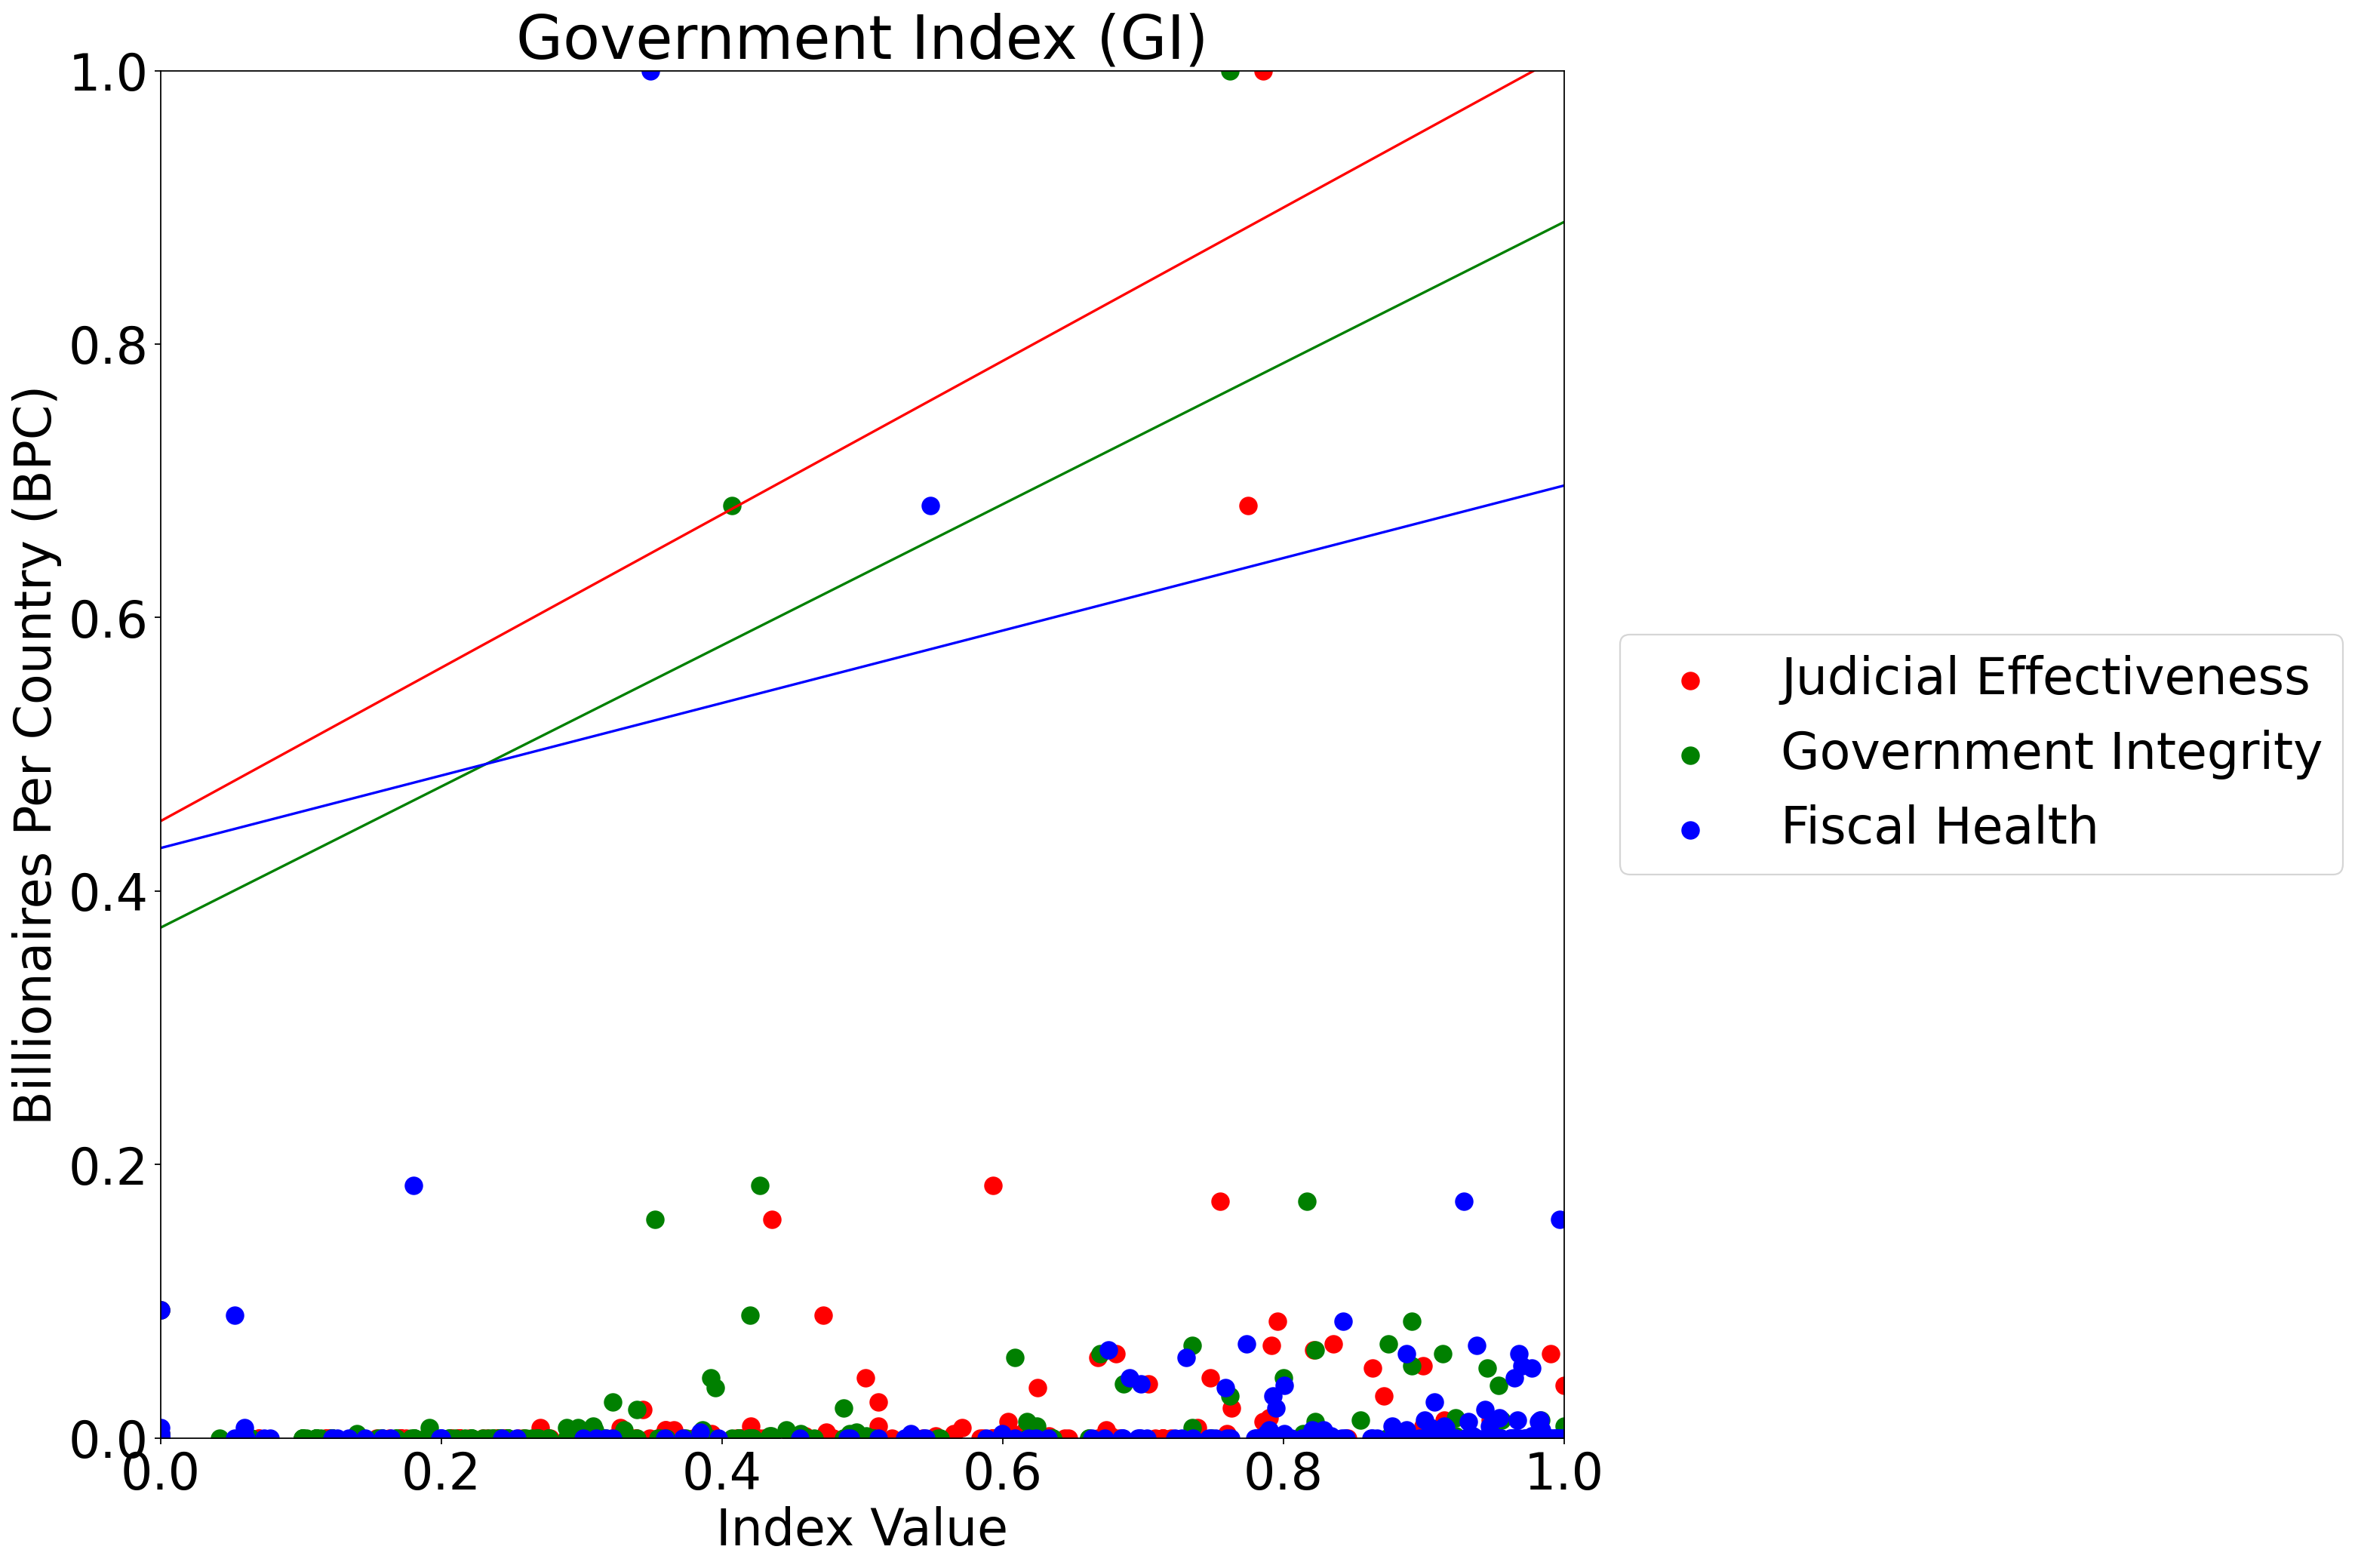

In [8]:
gi = eco[['judi_efct', 'govt_intg', 'fscl_hlth', 'ISO_A3']]
gi = pd.merge(gi, b_normal, left_on='ISO_A3', right_on='ISO_A3', how='outer')
gi.drop(columns='ISO_A3', axis=1, inplace=True)
for col in gi:
    gi[col] = gi[col].apply(lambda x: 0 if np.isnan(x) else (x-gi[col].min())/(gi[col].max()-gi[col].min()))

plt.figure(figsize=(15,15),dpi=80)
plt.rcParams.update({'font.size':30})
plt.title('Government Index (GI)')
plt.xlabel('Index Value')
plt.ylabel('Billionaires Per Country (BPC)')
plt.figsize=(30,30)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.scatter(gi['judi_efct'],
            gi['Billionaire_count'],
            s=100,
            c='red',
            label='Judicial Effectiveness')
plt.scatter(gi['govt_intg'],
            gi['Billionaire_count'],
            s=100,
            c='green',
            label='Government Integrity')
plt.scatter(gi['fscl_hlth'],
            gi['Billionaire_count'],
            s=100,
            c='blue',
            label='Fiscal Health')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

X=gi['Billionaire_count'].values
Y=gi['judi_efct'].values
Y_pred = lin_reg(X,Y)
plt.plot([min(gi['Billionaire_count'].values), 
          max(gi['judi_efct'].values)], 
         [min(Y_pred), max(Y_pred)], 
         color='red')
X=gi['Billionaire_count'].values
Y=gi['govt_intg'].values
Y_pred = lin_reg(X,Y)
plt.plot([min(gi['Billionaire_count'].values), 
          max(gi['govt_intg'].values)], 
         [min(Y_pred), max(Y_pred)], 
         color='green')
X=gi['Billionaire_count'].values
Y=gi['fscl_hlth'].values
Y_pred = lin_reg(X,Y)
plt.plot([min(gi['Billionaire_count'].values), 
          max(gi['fscl_hlth'].values)], 
         [min(Y_pred), max(Y_pred)], 
         color='blue')

plt.savefig('output/gi.png', bbox_inches='tight')
plt.show() 

#### *[C3] Tax Index (TI)*

-0.2721045727572252 0.2639230803807
0.35530510390223907 0.4469338603310778
-0.016248880858588 0.44855046135533055
0.0786671242242233 0.4298390042304992


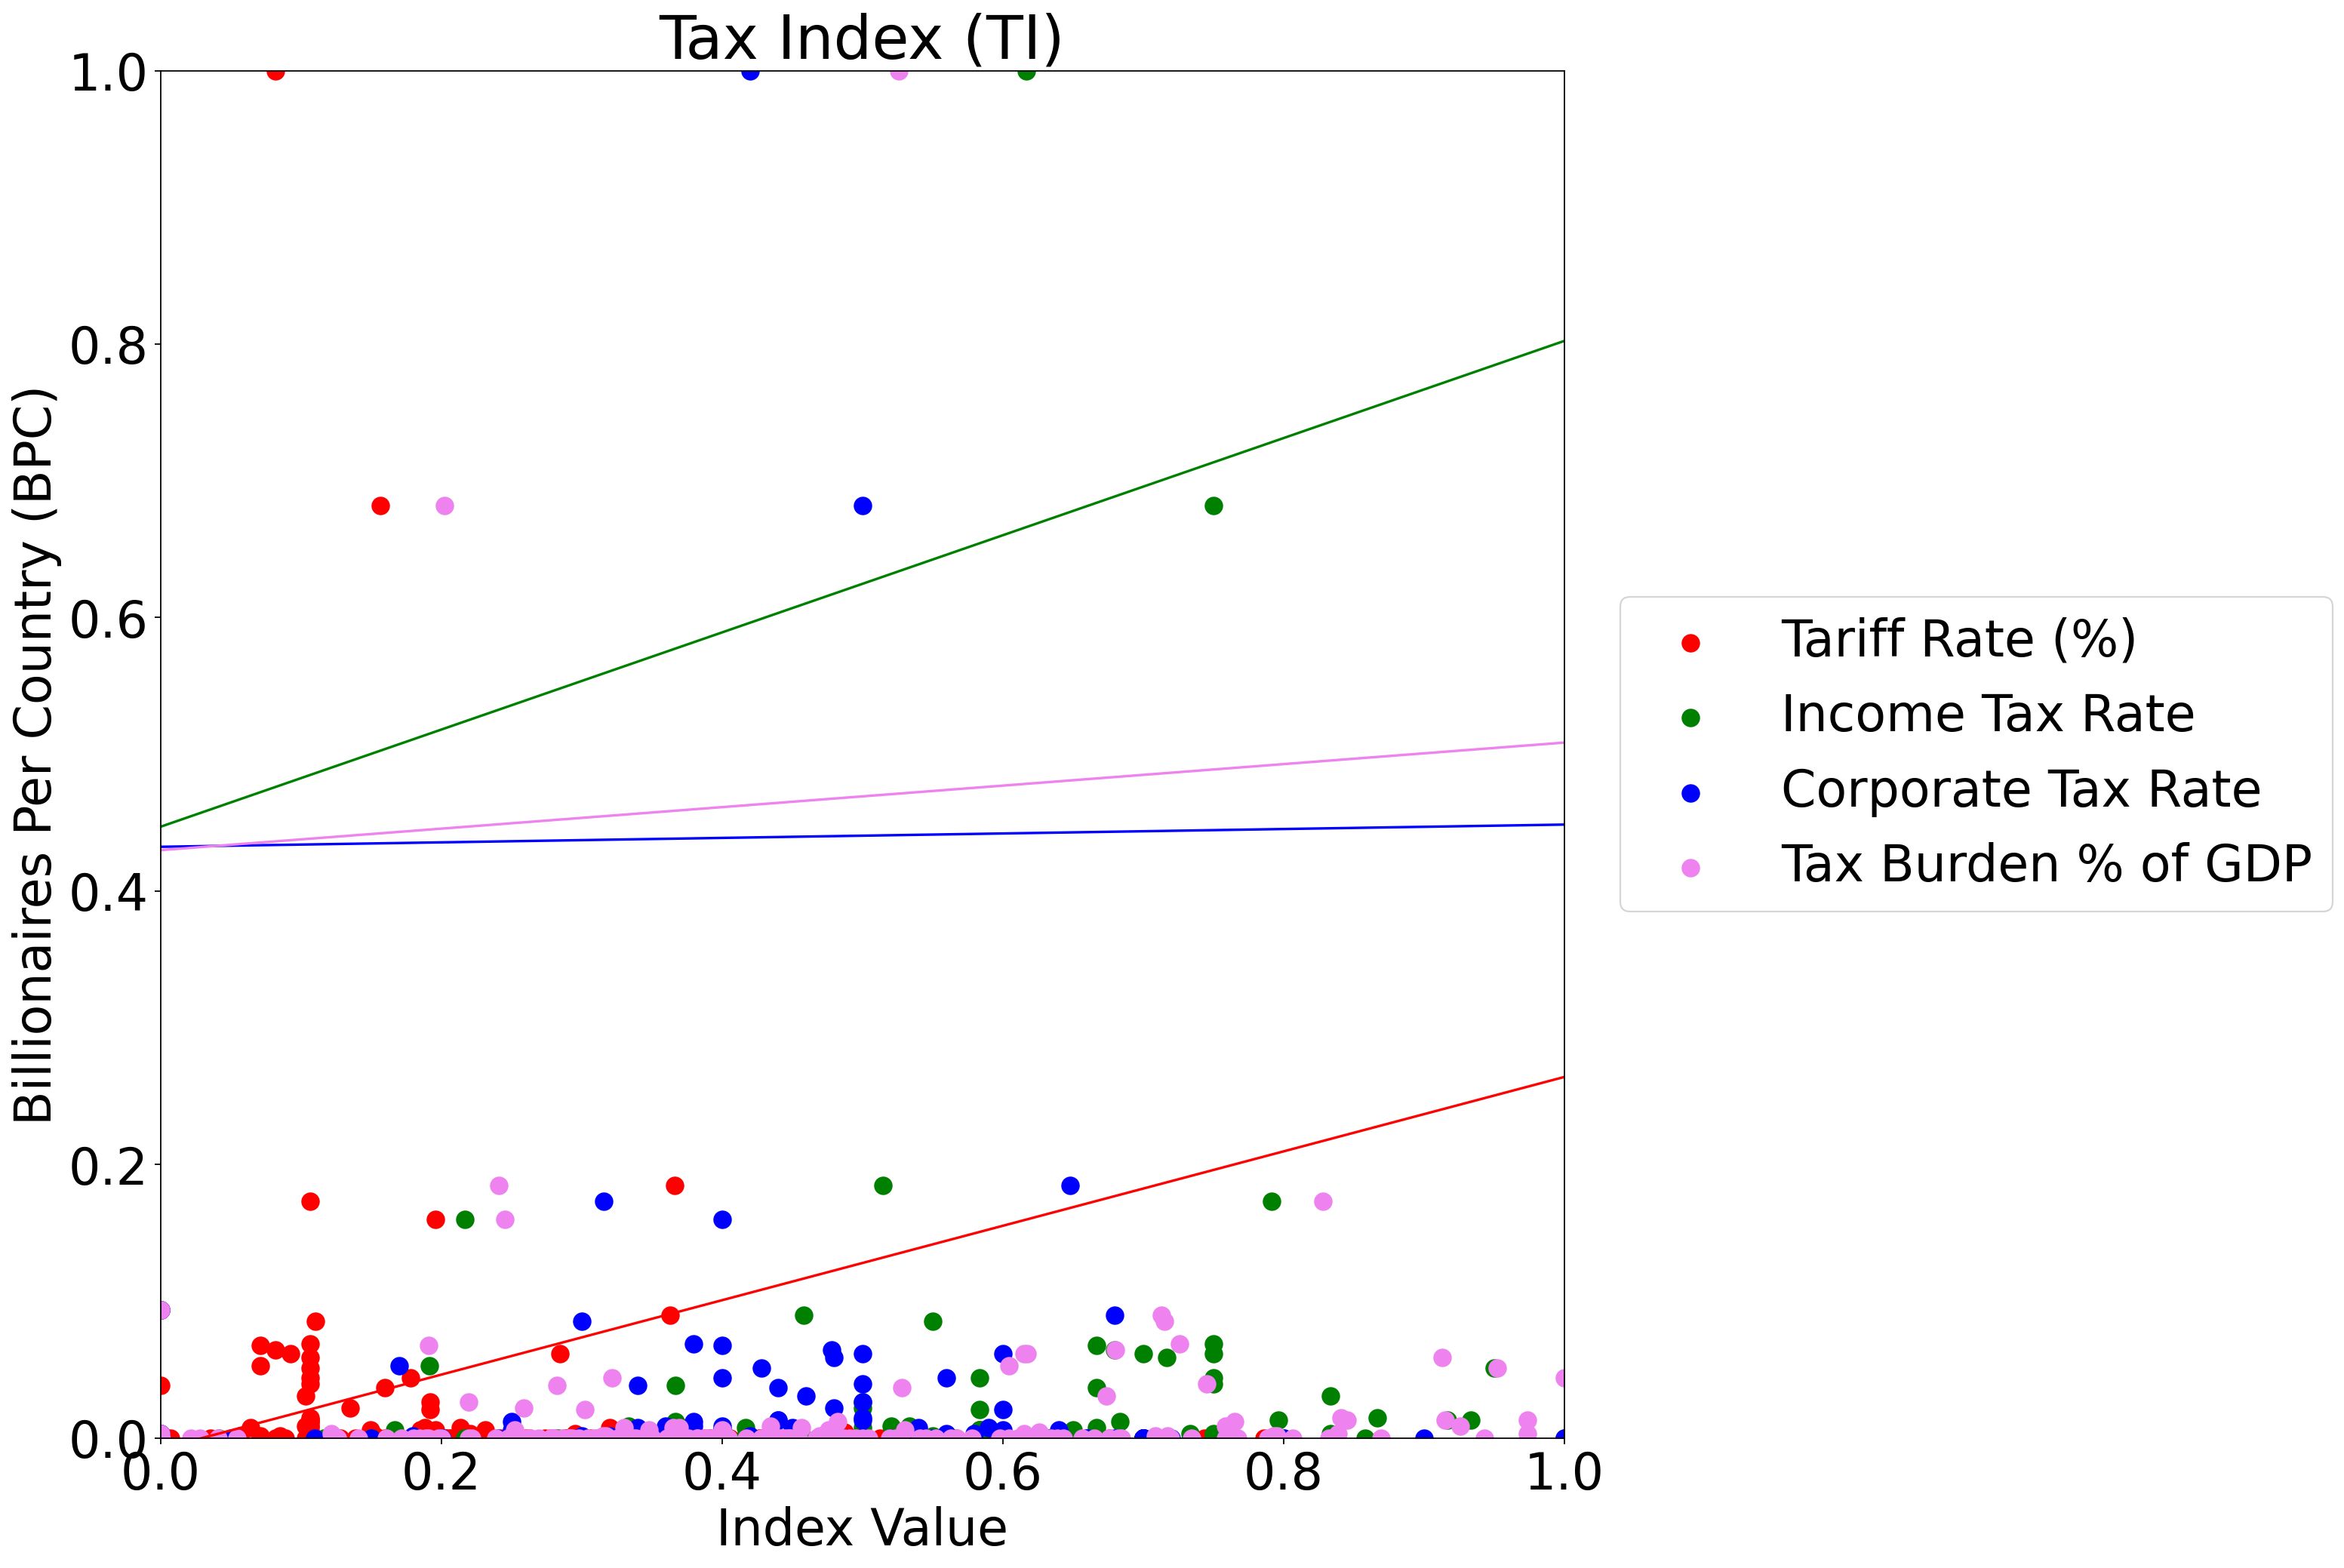

In [9]:
ti = eco[['trff_rate', 'incm_tax_rate', 'corp_tax_rate', 'tax_burd_gdp', 'ISO_A3']]
ti = pd.merge(ti, b_normal, left_on='ISO_A3', right_on='ISO_A3', how='outer')
ti.drop(columns='ISO_A3', axis=1, inplace=True)
for col in ti:
    ti[col] = ti[col].apply(lambda x: 0 if np.isnan(x) else (x-ti[col].min())/(ti[col].max()-ti[col].min()))

plt.figure(figsize=(15,15),dpi=80)
plt.rcParams.update({'font.size':30})
plt.title('Tax Index (TI)')
plt.xlabel('Index Value')
plt.ylabel('Billionaires Per Country (BPC)')
plt.figsize=(30,30)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.scatter(ti['trff_rate'],
            ti['Billionaire_count'],
            s=100,
            c='red',
            label='Tariff Rate (%)')
plt.scatter(ti['incm_tax_rate'],
            ti['Billionaire_count'],
            s=100,
            c='green',
            label='Income Tax Rate')
plt.scatter(ti['corp_tax_rate'],
            ti['Billionaire_count'],
            s=100,
            c='blue',
            label='Corporate Tax Rate')
plt.scatter(ti['tax_burd_gdp'],
            ti['Billionaire_count'],
            s=100,
            c='violet',
            label='Tax Burden % of GDP')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

X=ti['Billionaire_count'].values
Y=ti['trff_rate'].values
Y_pred = lin_reg(X,Y)
plt.plot([min(ti['Billionaire_count'].values), 
          max(ti['trff_rate'].values)], 
         [min(Y_pred), max(Y_pred)], 
         color='red')
X=ti['Billionaire_count'].values
Y=ti['incm_tax_rate'].values
Y_pred = lin_reg(X,Y)
plt.plot([min(ti['Billionaire_count'].values), 
          max(ti['incm_tax_rate'].values)], 
         [min(Y_pred), max(Y_pred)], 
         color='green')
X=ti['Billionaire_count'].values
Y=ti['corp_tax_rate'].values
Y_pred = lin_reg(X,Y)
plt.plot([min(ti['Billionaire_count'].values), 
          max(ti['corp_tax_rate'].values)], 
         [min(Y_pred), max(Y_pred)], 
         color='blue')
X=ti['Billionaire_count'].values
Y=ti['tax_burd_gdp'].values
Y_pred = lin_reg(X,Y)
plt.plot([min(ti['Billionaire_count'].values), 
          max(ti['tax_burd_gdp'].values)], 
         [min(Y_pred), max(Y_pred)], 
         color='violet')

plt.savefig('output/ti.png', bbox_inches='tight')
plt.show()